reference: https://www.youtube.com/watch?v=fqltiq5EahU

Developing a Momentum Trading Strategy

<ul>
<li>Testing out fast and slow simple moving averages.</li>

<li>We will pull Nifty50 data from yfinance, calculate both the fast and slow moving averages and finally include a buy/sell signal depending on whether the fast moving average has crossed the slow moving average from above or below.</li>
</ul>

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt

Step 1: Download data for the required ticker.

In [2]:
ticker = "^NSEI"
start="2020-01-01"
end="2024-12-31"

In [3]:
data = yf.download(ticker, start=start,end=end)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
data.columns = data.columns.droplevel(1)

In [5]:
data.drop(data.columns[[4]], axis=1, inplace=True)

In [6]:
day = np.arange(1,len(data)+1)
data['Day'] = day

In [7]:
# Rearranging the columns for ease
data = data[['Day', 'Open', 'High', 'Low', 'Close']]
data.head()

Price,Day,Open,High,Low,Close
Date,,,,,
2020-01-01,1,12202.150391,12222.200195,12165.299805,12182.500000
2020-01-02,2,12198.549805,12289.900391,12195.250000,12282.200195
2020-01-03,3,12261.099609,12265.599609,12191.349609,12226.650391
2020-01-06,4,12170.599609,12179.099609,11974.200195,11993.049805
2020-01-07,5,12079.099609,12152.150391,12005.349609,12052.950195


Step 2: Calculating our moving average crossover trading signal

In [8]:
data['9-day_SMA'] = data['Close'].rolling(9).mean().shift()
data['21-day_SMA'] = data['Close'].rolling(21).mean().shift()

# Without the 'shift' method, the above data implied that we have look-ahead information on what the closing price is going to be 
# before the end of the day, which of course is not the case. We will need to shift the moving averages one day ahead for our use case.

data[21:25]

Price,Day,Open,High,Low,Close,9-day_SMA,21-day_SMA
Date,,,,,,,
2020-01-30,22,12147.750000,12150.299805,12010.599609,12035.799805,12176.283203,12200.599935
2020-01-31,23,12100.400391,12103.549805,11945.849609,11962.099609,12141.111003,12193.614211
2020-02-03,24,11627.450195,11749.849609,11614.500000,11707.900391,12111.949870,12178.371326
2020-02-04,25,11786.250000,11986.150391,11783.400391,11979.650391,12060.622179,12153.668945


Add a signal column

In [9]:
# Like an if function on excel
data['Signal'] = np.where(data['9-day_SMA'] > data['21-day_SMA'], 1, 0)
data['Signal'] = np.where(data['9-day_SMA'] < data['21-day_SMA'], -1, data['Signal'])
data.dropna(inplace=True)

data.head()

Price,Day,Open,High,Low,Close,9-day_SMA,21-day_SMA,Signal
Date,,,,,,,,
2020-01-30,22,12147.750000,12150.299805,12010.599609,12035.799805,12176.283203,12200.599935,-1
2020-01-31,23,12100.400391,12103.549805,11945.849609,11962.099609,12141.111003,12193.614211,-1
2020-02-03,24,11627.450195,11749.849609,11614.500000,11707.900391,12111.949870,12178.371326,-1
2020-02-04,25,11786.250000,11986.150391,11783.400391,11979.650391,12060.622179,12153.668945,-1
2020-02-05,26,12005.849609,12098.150391,11953.349609,12089.150391,12046.483290,12153.030878,-1


Now, we calculate the buy and hold performance vs the performance of our trading algorithm

In [10]:
data['Return'] = np.log(data['Close']).diff()
data['Algo_Return'] = data['Return'] * data['Signal']
data['Entry'] = data['Signal'].diff()
data.head()

Price,Day,Open,High,Low,Close,9-day_SMA,21-day_SMA,Signal,Return,Algo_Return,Entry
Date,,,,,,,,,,,
2020-01-30,22,12147.750000,12150.299805,12010.599609,12035.799805,12176.283203,12200.599935,-1,NaN,NaN,NaN
2020-01-31,23,12100.400391,12103.549805,11945.849609,11962.099609,12141.111003,12193.614211,-1,-0.006142,0.006142,0.0
2020-02-03,24,11627.450195,11749.849609,11614.500000,11707.900391,12111.949870,12178.371326,-1,-0.021479,0.021479,0.0
2020-02-04,25,11786.250000,11986.150391,11783.400391,11979.650391,12060.622179,12153.668945,-1,0.022946,-0.022946,0.0
2020-02-05,26,12005.849609,12098.150391,11953.349609,12089.150391,12046.483290,12153.030878,-1,0.009099,-0.009099,0.0


We plot the data on a time-series to visualize the returns of our algorithm vs a buy-and-hold strategy

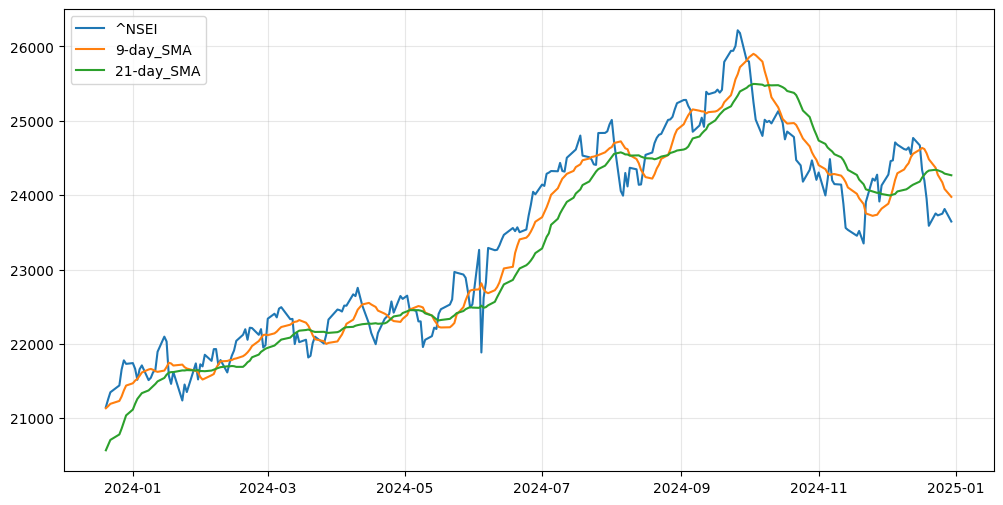

In [12]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data.iloc[-252:]['Close'], label = ticker)
plt.plot(data.iloc[-252:]['9-day_SMA'], label = '9-day_SMA')
plt.plot(data.iloc[-252:]['21-day_SMA'], label = '21-day_SMA')
'''plt.plot(data[-252:].loc[data.entry == 2].index, data[-252:]['9-day_SMA'][data.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(data[-252:].loc[data.entry == -2].index, data[-252:]['21-day_SMA'][data.entry == -2], 'v',
         color = 'r', markersize = 12)'''
plt.legend(loc=2);

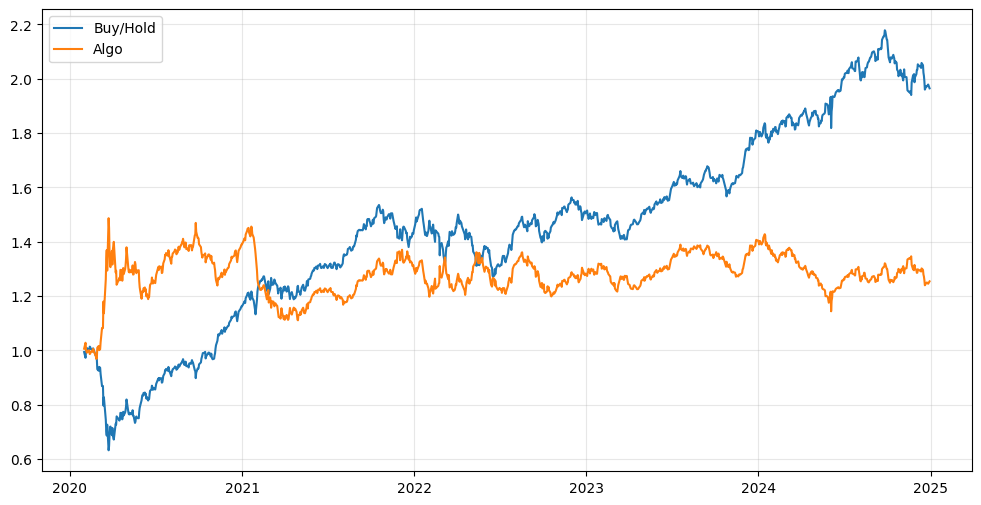

In [13]:
plt.plot(np.exp(data['Return']).cumprod(), label='Buy/Hold')
plt.plot(np.exp(data['Algo_Return']).cumprod(), label='Algo')
plt.legend(loc=2)
plt.grid(True, alpha=.3)

In [14]:
np.exp(data['Return']).cumprod()[-1] -1

/tmp/ipykernel_40735/2472558281.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(data['Return']).cumprod()[-1] -1


np.float64(0.9645474978252864)

In [15]:
np.exp(data['Algo_Return']).cumprod()[-1] -1

/tmp/ipykernel_40735/806574396.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.exp(data['Algo_Return']).cumprod()[-1] -1


np.float64(0.25405213588281517)

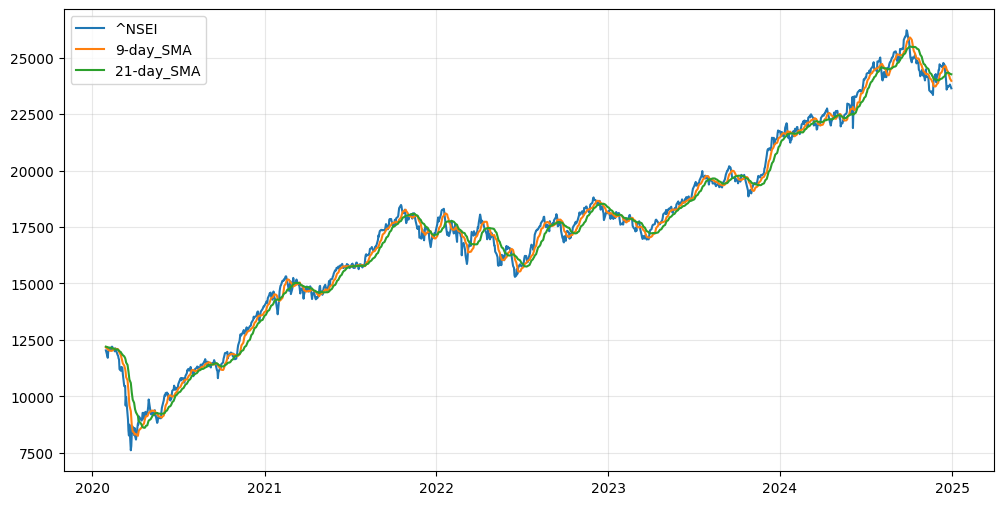

In [16]:
plt.rcParams['figure.figsize'] = 12, 6
plt.grid(True, alpha = .3)
plt.plot(data['Close'], label = ticker)
plt.plot(data['9-day_SMA'], label = '9-day_SMA')
plt.plot(data['21-day_SMA'], label = '21-day_SMA')
'''plt.plot(data.loc[data.entry == 2].index, data['9-day_SMA'][data.entry == 2], '^',
         color = 'g', markersize = 12)
plt.plot(dataloc[data.entry == -2].index, data['21-day_SMA'][data.entry == -2], 'v',
         color = 'r', markersize = 12)'''
plt.legend(loc=2);